In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Utils

In [3]:
def get_dataloaders(batch_size=128):
    
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.490, 0.451), (0.214, 0.197, 0.191))

    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.490, 0.451), (0.214, 0.197, 0.191))

    ])
    
    train_dataset = CIFAR10(
        root="./data", train=True, download=True, transform=train_transform,
    )

    test_dataset = CIFAR10(
        root="./data", train=False, download=True, transform=test_transform,
    )

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
    )

    return train_loader, test_loader

In [4]:
def get_training_protocol(model, lr=0.1, momentum=0.9, weight_decay=0.0001):
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer,
        mode='min',
        factor=0.1,
        patience=5,
        threshold=0.0001
    )

    return criterion, optimizer, scheduler

In [5]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()

    correct = 0.0
    total = 0.0

    loss_per_epoch = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_per_epoch += loss.item()

        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    loss_per_epoch /= len(train_loader)
    accuracy = correct / total
    return loss_per_epoch, accuracy

In [6]:
def validate(model, test_loader, criterion, device):
    model.eval()

    correct = 0.0
    total = 0.0

    loss_per_epoch = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss_per_epoch += loss.item()

            predicted = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    loss_per_epoch /= len(test_loader)

    return loss_per_epoch, accuracy

In [7]:
def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):

    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot loss curves
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy curves
    ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

In [8]:
def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):

    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot loss curves
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy curves
    ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# DenseNet-40 Architecture

In [9]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DenseLayer, self).__init__()

        self.dense_layer = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        )
    
    def forward(self, x):
        out = self.dense_layer(x)
        return torch.cat([x, out], dim=1)

In [10]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()

        layers = []

        in_channels = in_channels
        for _ in range(num_layers):
            layers.append(DenseLayer(in_channels, growth_rate))
            in_channels += growth_rate

        self.dense_block = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.dense_block(x)
        return x

In [11]:
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()

        self.transition = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
    
    def forward(self, x):
        x = self.transition(x)
        return x

In [12]:
class DenseNet40(nn.Module):
    def __init__(self, in_channels, out_channels, k=12, L=40, num_classes=10):
        """
        Args:
            k (int): Growth rate,
            L (int): Number of dense layers 
        """
        
        super(DenseNet40, self).__init__()

        # Initial number of features
        self.num_init_features = 16
        
        # Initial Convolutional Block
        self.initial_conv = nn.Sequential(
            nn.Conv2d(
                3, self.num_init_features, kernel_size=3, stride=1, padding=1, bias=False
            )
        )

        # Dense Blocks and Transition Layers
        self.dense_blocks = self._make_dense_block(k, (L - 4) // 3, 3)

        # Final BatchNorm and ReLU
        self.final_bn = nn.BatchNorm2d(self.num_features)
        self.final_relu = nn.ReLU(inplace=True)

        # Global Average Pooling layer
        self.gap = nn.AdaptiveAvgPool2d((1,1))

        self.classifier = nn.Linear(self.num_features, num_classes)
    
    def _make_dense_block(self, growth_rate, num_layers, num_blocks):
        dense_blocks = []

        num_features = self.num_init_features

        for _ in range(num_blocks):
            dense_blocks.append(DenseBlock(num_features, growth_rate, num_layers))
            
            num_features = num_features + num_layers * growth_rate # num_features + num_layers * growth_rate
            
            if _ != num_blocks - 1:  # No transition layer after the last dense block
                dense_blocks.append(TransitionLayer(num_features, num_features))
        
        self.num_features = num_features

        return nn.Sequential(*dense_blocks)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, 0, 0.01)
                init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.dense_blocks(x)
        x = self.final_bn(x)
        x = self.final_relu(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Training

In [17]:
densenet_40_model = DenseNet40(in_channels=3, out_channels=16, k=12, L=40, num_classes=10).to(device)
densenet_40_model._initialize_weights()
print(densenet_40_model)

DenseNet40(
  (initial_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (dense_blocks): Sequential(
    (0): DenseBlock(
      (dense_block): Sequential(
        (0): DenseLayer(
          (dense_layer): Sequential(
            (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv2d(16, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
        )
        (1): DenseLayer(
          (dense_layer): Sequential(
            (0): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv2d(28, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
        )
        (2): DenseLayer(
          (dense_layer): Sequential(
            (0): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [18]:
criterion, optimizer, scheduler = get_training_protocol(densenet_40_model, lr=0.1, momentum=0.9, weight_decay=0.0001)

In [19]:
train_loader, test_loader = get_dataloaders(batch_size=64)

In [20]:
EPOCHS = 50

train_history = {"train_loss":[], "train_acc":[]}
val_history = {"val_loss":[], "val_acc":[]}

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(densenet_40_model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(densenet_40_model, test_loader, criterion, device)

    scheduler.step(val_loss)

    train_history["train_loss"].append(train_loss)
    train_history["train_acc"].append(train_acc)
    
    val_history["val_loss"].append(val_loss)
    val_history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("\nTraining Complete")


Epoch 1/50 - Train Loss: 1.5305, Train Acc: 0.4417, Val Loss: 1.2829, Val Acc: 0.5646
Epoch 2/50 - Train Loss: 1.0084, Train Acc: 0.6421, Val Loss: 1.0258, Val Acc: 0.6558
Epoch 3/50 - Train Loss: 0.8109, Train Acc: 0.7133, Val Loss: 0.8397, Val Acc: 0.7047
Epoch 4/50 - Train Loss: 0.6911, Train Acc: 0.7604, Val Loss: 0.7950, Val Acc: 0.7393
Epoch 5/50 - Train Loss: 0.6146, Train Acc: 0.7863, Val Loss: 0.7067, Val Acc: 0.7795
Epoch 6/50 - Train Loss: 0.5607, Train Acc: 0.8037, Val Loss: 0.5951, Val Acc: 0.8056
Epoch 7/50 - Train Loss: 0.5213, Train Acc: 0.8187, Val Loss: 0.8040, Val Acc: 0.7395
Epoch 8/50 - Train Loss: 0.4913, Train Acc: 0.8318, Val Loss: 0.6313, Val Acc: 0.7908
Epoch 9/50 - Train Loss: 0.4622, Train Acc: 0.8406, Val Loss: 0.7837, Val Acc: 0.7528
Epoch 10/50 - Train Loss: 0.4401, Train Acc: 0.8477, Val Loss: 0.5638, Val Acc: 0.8083
Epoch 11/50 - Train Loss: 0.4262, Train Acc: 0.8516, Val Loss: 0.6348, Val Acc: 0.8049
Epoch 12/50 - Train Loss: 0.4091, Train Acc: 0.8604,

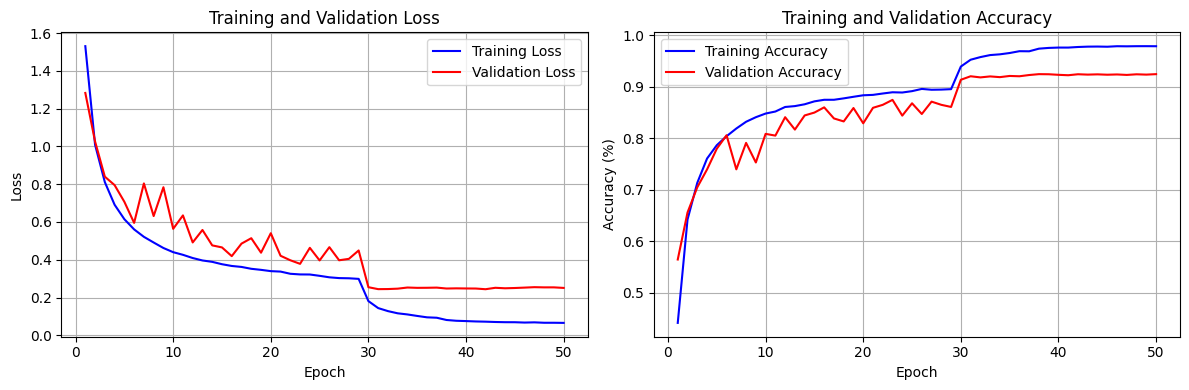

In [21]:
plot_learning_curves(train_history["train_loss"], val_history["val_loss"], train_history["train_acc"], val_history["val_acc"])